In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image
from typing import List, Dict
import copy
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tempfile, os

supported_models = ['resnet18', 'resnet50', 'resnet101', 'vgg16_bn', 'vgg19_bn', 'inception_v3']
model_name = supported_models[1]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# if str(device) == 'cpu':
#     raise RuntimeError("cuda is NOT available!!")

benign_pic = './data/cat/Cat04.jpg'

# Constants

In [2]:
imagenet_mean=torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
imagenet_std=torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

In [3]:
epsilon = 1 / 255. / imagenet_std
epsilon

tensor([[[0.0171]],

        [[0.0175]],

        [[0.0174]]], device='cuda:0')

# Utilities

## Visualize

In [4]:
def visualize(x, adv, benign_label:int, adv_label:int, height:int=10, width:int=20):
    def restore(x):
        x = x * imagenet_std + imagenet_mean
        return x

    x, adv = restore(x).cpu(), restore(adv).cpu()
    x, adv = x.numpy().transpose([0, 2, 3, 1]), adv.numpy().transpose([0, 2, 3, 1]) # transpose (bs, C, H, W) back to (bs, H, W, C)
    plt.figure(figsize=(height, width))
    
    plt.subplot(1, 2, 1)
    # predicted_class, predicted_classname, confidence = classify_image(model, benign_pic, class_labels)
    plt.title(f"Benign: {class_labels[benign_label]}")
    plt.axis('off')
    plt.imshow(x.squeeze())
    
    plt.subplot(1, 2, 2)
    plt.title(f"Adversary: {class_labels[adv_label]}")
    plt.axis('off')
    plt.imshow(adv.squeeze())

    plt.tight_layout()

## Store

In [5]:
def store_img_tensor(x, img_path:str):
    def restore(x):
        x = x * imagenet_std + imagenet_mean
        return x.squeeze()
    x = restore(x)
    image = transforms.ToPILImage()(x)
    image.save(img_path)

# Create model

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py).

Model label list is ImageNet labels which can be found [here](https://files.fast.ai/models/imagenet_class_index.json)

In [6]:
class ModelFactory():
    _instance = None
    _supported_models = []
    _models = {}
    _class_labels = None

    def _fill_classlabels(self):
        class_file = 'imagenet_class_index.json'
        with open(class_file, 'r') as f:
            f_contents = f.read()
        class_labels = json.loads(f_contents)
        self._class_labels = {int(k):v[1] for k, v in class_labels.items()}
        
    def __new__(self, supported_models, *args, **kwargs):
        if not self._instance:
            self._instance = super(ModelFactory, self).__new__(self, *args, **kwargs)
            self._supported_models = copy.deepcopy(supported_models)
            self._models = dict()
            self._fill_classlabels(self)
        return self._instance
            
    def get_supported_models(self)->List[str]:
        return self.supported_models

    def get_model(self, model_name):
        m = model_name.lower()
        # import ipdb; ipdb.set_trace()
        try:
            self._supported_models[self._supported_models.index(m)]
        except ValueError as ve:
            raise ValueError(f"Not supported model: {model_name} - {ve.args}")
        model = self._models.get(m)
        if not model: # model is not yet initialized
            print(f"{m} is not yet initialized, create a new one!")
            model = models.get_model_builder(m)(pretrained=True).to(device)
            model.requires_grad_(False)
            model.eval()
            self._models[m] = model
        else:
            print(f"{m} is already initialized, return directly!")
        return self._models.get(m)

    def get_class_labels(self):
        return self._class_labels

model_factory = ModelFactory(supported_models)
class_labels = model_factory.get_class_labels()

# Classify picture

In [7]:
# Preprocess the image
def preprocess_image(image_path:str):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        # transforms.Resize(size=256),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(), # Convert the image to a tensor
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std) # Normalize the image
    ])
    # print(f"Before transform, image.shape = {transforms.Compose([transforms.ToTensor()])(image).shape}")
    preprocessed_image = transform(image).to(device)
    # print(f"After transform, image.shape = {preprocessed_image.shape}")
    # preprocessed_image = preprocessed_image * imagenet_std + imagenet_mean
    preprocessed_image = torch.unsqueeze(preprocessed_image, 0)  # Add a batch dimension
    return preprocessed_image

def get_logits(model, image_path:str):
    preprocessed_image = preprocess_image(image_path)
    with torch.no_grad():
        logits = model(preprocessed_image)
    return logits

# Classify the image
def classify_image(model, image_path:str, class_labels:Dict[int, str]):
    logits = get_logits(model, image_path)
    # import ipdb; ipdb.set_trace()
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities.squeeze()).item()
    predicted_classname = class_labels[predicted_class]
    confidence = probabilities.squeeze()[predicted_class]
    return predicted_class, predicted_classname, confidence, probabilities

## Check result of benign examples

In [8]:
model = model_factory.get_model(model_name)
predicted_class, predicted_classname, confidence, probabilities = classify_image(model, benign_pic, class_labels)
print(f'Predicted class: {predicted_classname} (No: {predicted_class:d}, with confidence: {confidence:.1%})')

resnet50 is not yet initialized, create a new one!


/home/llm/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/llm/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class: tabby (No: 281, with confidence: 4.6%)


# gradient

In order to calculate gradient, we'll use cross-entropy loss here:

$$\text{CrossEntropyLoss} = - \sum{_{i=1}^{N} \left( y_{i}\log{(p_{i})}+(1-y_{i})\log{(1-p_{i})} \right)}$$

Note, the `F.cross_entropy` or `nn.CrossEntropyLoss` is calculated as follows:

1. Apply a softmax function to the raw scores to get a probability distribution.
2. Compute the negative log-likelihood loss against the given labels.

So, the result of the following code is NOT `tensor(0.)` but `tensor(0.9048)` because the `F.cross_entropy` calculates `softmax` first on the input (`pred`) and thus the value of the zeroth index is no longer `1.`:

```python
loss_fn = F.cross_entropy
pred = torch.tensor([[1., 0, 0, 0, 0]])
labels = torch.tensor([0])
loss_fn(pred, labels)
```

Comparing with the following code which outputs resulting loss very close to `0`:

```python
loss_fn = F.cross_entropy
pred = torch.tensor([[10., 0, 0, 0, 0]])
labels = torch.tensor([0])
loss_fn(pred, labels)
```

Here, because the zeroth-index of `pred` is large enough comparing to others value, after `softmax`, the zeroth-index of the output (the input of the `negative log-likelihood`) is very close to `1.`, the output loss is thus very close the `0.`.

## non-target gradient

In [9]:
def non_target_grad(model, pic:str, ground_truth:int, loss_fn=F.cross_entropy):
    y = torch.tensor([ground_truth]).to(device)
    x = preprocess_image(pic)
    # import ipdb; ipdb.set_trace()
    x.requires_grad = True
    y_hat = model(x)
    loss = -loss_fn(y_hat, y)
    print(f"loss = {loss:.4f}")
    loss.backward()
    return x.grad

model = model_factory.get_model(model_name)
x_grad = non_target_grad(model, pic=benign_pic, ground_truth=predicted_class)

print(f"\nx_grad.shape = {x_grad.shape}")

resnet50 is already initialized, return directly!
loss = -3.0817

x_grad.shape = torch.Size([1, 3, 1080, 1080])


## target gradient

In [10]:
def target_grad_by_x(model, x, ground_truth:int, target:int, loss_fn=F.cross_entropy):
    y_true = torch.tensor([ground_truth]).to(device)
    y_target = torch.tensor([target]).to(device)
    x0 = x.detach().clone() # * imagenet_std + imagenet_mean
    x0.requires_grad = True
    y_hat = model(x0)
    
    true_loss = loss_fn(y_hat, y_true)
    target_loss = loss_fn(y_hat, y_target)
    adv_loss = -true_loss + target_loss

    adv_loss.backward()
    return x0.grad, true_loss, target_loss, adv_loss

def target_grad_by_file(model, pic:str, ground_truth:int, target:int, loss_fn=F.cross_entropy):
    y_true = torch.tensor([ground_truth]).to(device)
    y_target = torch.tensor([target]).to(device)
    x = preprocess_image(pic)
    
    x_grad, true_loss, target_loss, adv_loss = target_grad_by_x(model, x, ground_truth, target, loss_fn)
    return x_grad, true_loss, target_loss, adv_loss

model = model_factory.get_model(model_name)

target_id = 508 # computer_keyboard
x_grad, true_loss, target_loss, adv_loss = target_grad_by_file(model, pic=benign_pic, ground_truth=predicted_class, target=target_id)

print(f"\nx_grad.shape = {x_grad.shape}")

resnet50 is already initialized, return directly!

x_grad.shape = torch.Size([1, 3, 1080, 1080])


# Attacking algorithms

## fgsm

In [11]:
def fgsm(benign_pic:str, model, predicted_class:int, target_id:int):
    x = preprocess_image(benign_pic)
    x_grad, true_loss0, target_loss0, adv_loss0 = target_grad_by_file(model, benign_pic, 
                                                           ground_truth=predicted_class, 
                                                           target=target_id)
    adv_x = x - epsilon * x_grad.sign()
    adv_file = tempfile.NamedTemporaryFile().name + ".jpg"
    store_img_tensor(adv_x, adv_file)
    print(f"{'#' * 20}")
    target_grad_by_file(model, adv_file, ground_truth=predicted_class, target=target_id) # See if the loss decreased
    return adv_x, x_grad, adv_file

# predicted_class, predicted_classname, confidence, probabilities = classify_image(model, benign_pic, class_labels)
# print(f'Predicted class: {predicted_classname} (No: {predicted_class:d}, with confidence: {confidence:.1%})')

# target_id = 508 # computer_keyboard
# adv_x, x_grad, adv_file = fgsm(benign_pic, model, predicted_class, target_id)

# adv_predicted_class, adv_predicted_classname, adv_confidence, adv_probabilities = classify_image(model, adv_file, class_labels)
# print(f'Predicted class: {adv_predicted_classname} (No: {adv_predicted_class:d}, with confidence: {adv_confidence:.1%})')

# visualize(preprocess_image(benign_pic), adv_x, predicted_class, adv_predicted_class)

# os.remove(adv_file)

## ifgsm

In [15]:
def ifgsm(benign_pic:str, model, predicted_class:int, target_id:int, num_iterate:int=200, alpha=None):
    alpha = alpha if alpha!=None else epsilon / num_iterate
    x = preprocess_image(benign_pic)
    clip_ratio = 1.5
    clip_arrange = [x + clip_ratio * epsilon, x - clip_ratio * epsilon]
    adv_x = x.detach().clone()

    true_losses = []
    target_losses = []
    adv_losses = []
    display_interval = 25
    for i in range(num_iterate):
        adv_file = tempfile.NamedTemporaryFile().name + ".jpg"
        store_img_tensor(adv_x, adv_file)
        x_grad, true_loss, target_loss, adv_loss = target_grad_by_file(
            model, pic=adv_file, 
            ground_truth=predicted_class, 
            target=target_id)
        
        if i % display_interval == 0:
            # import ipdb; ipdb.set_trace()
            print(f"true_loss = {true_loss:.4f},\ttarget_loss = {target_loss:.4f},\t\adv_loss = -{adv_loss:.4f} + {target_loss:.4f} = {-true_loss + target_loss:.4f}")
        
        true_losses.append(true_loss)
        target_losses.append(target_loss)
        adv_losses.append(adv_loss)

        adv_x = adv_x - alpha * x_grad.detach().sign()
        adv_x = torch.max(torch.min(adv_x, clip_arrange[0]), clip_arrange[1]) # clip new x_adv back to [x-epsilon, x+epsilon]

        os.remove(adv_file)
    
    return adv_x, true_losses, target_losses, adv_losses

# Test

model = model_factory.get_model(model_name)

target_id = 508 # computer_keyboard

predicted_class, predicted_classname, confidence, probabilities = classify_image(model, benign_pic, class_labels)
print(f"\nFor {benign_pic}:")
print(f'Predicted class: {predicted_classname} (No: {predicted_class:d}, with confidence: {confidence:.1%}).')
print(f"The target classname is: {class_labels[target_id]} (No. {target_id}) with confidence: {probabilities[0][target_id]:.1%}")

resnet50 is already initialized, return directly!

For ./data/cat/Cat04.jpg:
Predicted class: tabby (No: 281, with confidence: 4.6%).
The target classname is: computer_keyboard (No. 508) with confidence: 0.3%


In [16]:
num_iterate=100
adv_x, true_losses, target_losses, adv_losses = ifgsm(benign_pic, model, predicted_class, target_id, num_iterate=num_iterate, alpha=35*epsilon/num_iterate)
adv_file = tempfile.NamedTemporaryFile().name + ".jpg"
store_img_tensor(adv_x, adv_file)

true_loss = 2.9530,	target_loss = 5.8716,	dv_loss = -2.9186 + 5.8716 = 2.9186
true_loss = 1.4158,	target_loss = 17.5657,	dv_loss = -16.1499 + 17.5657 = 16.1499
true_loss = 1.6956,	target_loss = 26.4697,	dv_loss = -24.7741 + 26.4697 = 24.7741
true_loss = 1.9350,	target_loss = 28.7049,	dv_loss = -26.7699 + 28.7049 = 26.7699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



For /tmp/tmpj3t7gx7d.jpg:
Predicted class: tiger_cat (No: 282, with confidence: 76.3%).
The target classname is: computer_keyboard (No. 508) with confidence: 0.0%


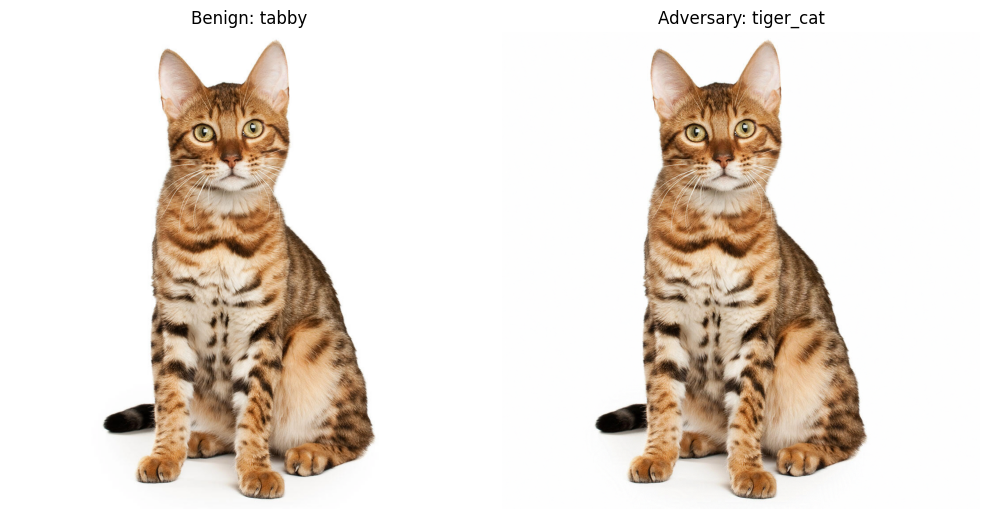

In [17]:
adv_predicted_class, adv_predicted_classname, adv_confidence, adv_probabilities = classify_image(model, adv_file, class_labels)
print(f"\nFor {adv_file}:")
print(f'Predicted class: {adv_predicted_classname} (No: {adv_predicted_class:d}, with confidence: {adv_confidence:.1%}).')
print(f"The target classname is: {class_labels[target_id]} (No. {target_id}) with confidence: {adv_probabilities[0][target_id]:.1%}")
os.remove(adv_file)
visualize(preprocess_image(benign_pic), adv_x, predicted_class, adv_predicted_class)

## Check result of adversary examples